# 1. Import Dependencies and Data

In [1]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

/Users/amruthashok/miniforge3/envs/mlp1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def parser(record):
    keys_to_features = {
        "image_raw": tf.io.FixedLenFeature([], tf.string),
        "label":     tf.io.FixedLenFeature([], tf.int64)
    }
    parsed = tf.io.parse_single_example(record, keys_to_features)
    image = tf.io.decode_raw(parsed["image_raw"], tf.uint8)
    image = tf.cast(image, tf.uint32)
    image = tf.reshape(image, shape=[128, 128, 1])
    image = image/255
    label = tf.cast(parsed["label"], tf.int32)

    return {'image': image}

def scale_image(data):
    image = data[0]
    return image/255

def input_fn(filenames):
  dataset = tf.data.TFRecordDataset(filenames=filenames, num_parallel_reads=40)
  ds = dataset
  # ds = ds.map(scale_image)
  ds = ds.map(parser)
  ds = ds.cache()
  ds = ds.shuffle(60000)
  # ds = ds.batch(1)
  ds = ds.prefetch(64)
  dataset = ds
  return dataset

ds = input_fn('train.tfrecords')

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-04-09 18:21:50.556403: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-09 18:21:50.557202: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# 2. Viz Data and Build Dataset

In [4]:
# Do some data transformation
import numpy as np

In [5]:
ds

<PrefetchDataset element_spec={'image': TensorSpec(shape=(128, 128, 1), dtype=tf.float64, name=None)}>

In [6]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [7]:
# Getting data out of the pipeline
dataiterator.next()['image'].shape

2023-04-09 18:21:57.894718: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(128, 128, 1)

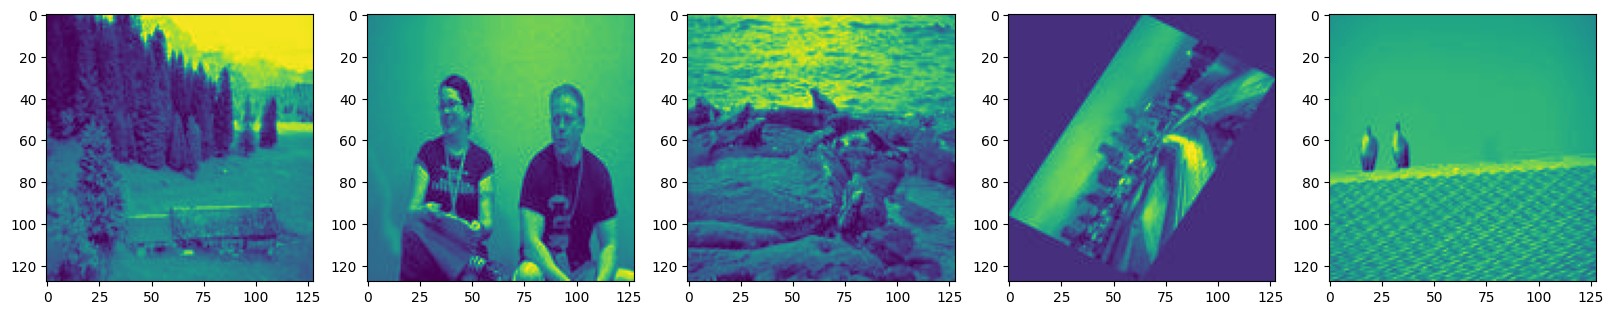

In [8]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
# Loop four times and get images 
for idx in range(5): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image']))
   

In [9]:
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255

In [10]:
# Reload the dataset 
ds = input_fn('train.tfrecords')
# Running the dataset through the scale_images preprocessing step
# ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [11]:
batch = ds.as_numpy_iterator().next()

In [12]:
batch = batch['image']

In [13]:
batch.shape

(128, 128, 128, 1)

# 3. Build Neural Network

### 3.1 Import Modelling Components

In [14]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, MaxPooling2D

### 3.2 Build Generator

In [15]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 8x8x128
    # Beginnings of a generated image
    model.add(Dense(8*8*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((8,8,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 3 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 4 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 3
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [16]:
generator = build_generator()

In [17]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              1056768   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                        

In [18]:
img = generator.predict(np.random.randn(4,128,1))

2023-04-09 18:22:21.453202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 787ms/step


1/1 [==============================] - 0s 49ms/step


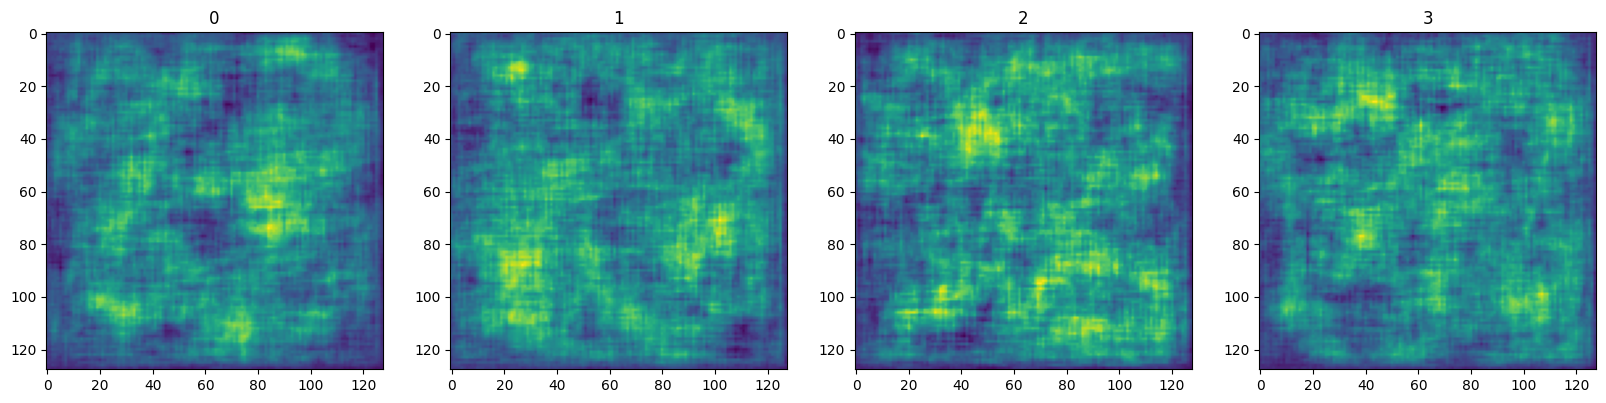

In [19]:
# Generate new
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

### 3.3 Build Discriminator

In [20]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (128,128,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # First MaxPooling2D
    model.add(MaxPooling2D(pool_size=(4, 4)))

    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fifth Conv Block
    model.add(Conv2D(512, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second MaxPooling2D
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third MaxPooling2D
    model.add(MaxPooling2D(pool_size=(4, 4)))


    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [21]:
discriminator = build_discriminator()

In [22]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 124, 124, 32)      832       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 124, 124, 32)      0         
                                                                 
 dropout (Dropout)           (None, 124, 124, 32)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 120, 120, 64)      51264     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 120, 120, 64)      0         
                                                                 
 dropout_1 (Dropout)         (None, 120, 120, 64)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 116, 116, 128)    

# 4. Construct Training Loop

### 4.1 Setup Losses and Optimizers

In [23]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [24]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Build Subclassed Model

In [25]:
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

In [27]:
class FakeGenGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch['image']
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [28]:
# Create instance of subclassed model
gan = FakeGenGAN(generator, discriminator)

In [29]:
# Compile the model
gan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [30]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [31]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

### 4.3 Train 

In [32]:
# Recommend 2000 epochs
hist = gan.fit(ds, epochs=10, callbacks=[ModelMonitor()])

Epoch 1/10


2023-04-09 18:25:00.652259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### 4.4 Review Performance

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

### 5 Save the Model

In [ ]:
generator.save('generator100.h5')
discriminator.save('discriminator100.h5')